In [1]:
%pylab inline
import glob
import sklearn.feature_extraction.image
pylab.rcParams['figure.figsize'] = (15.0, 10.0)

Populating the interactive namespace from numpy and matplotlib


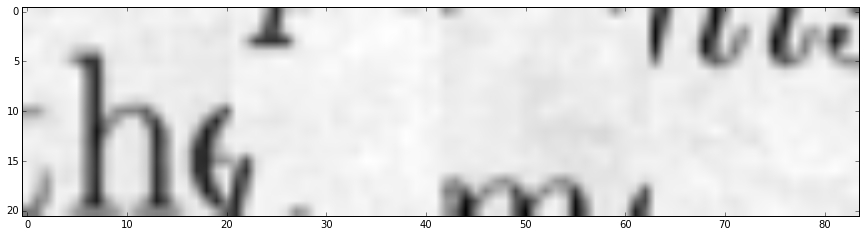

In [2]:
patch_size = 21
patch_center = patch_size / 2
max_patches = 10000
n_images = 20

all_images = [int(filter(char.isdigit, image)) for image in glob.glob("train/*.png")]
all_train_images = [i for i in all_images if i % 5]
all_valid_images = [i for i in all_images if not i % 5]

def batch(mode, flatten=False):
    if mode == 'train':
        images = np.random.choice(all_train_images, n_images)
    else:
        images = np.random.choice(all_valid_images, n_images)

    X_patches = np.zeros((0, patch_size, patch_size))
    y_patches = np.zeros((0, patch_size, patch_size))
    
    for image in images:
        X_image = imread('train/%d.png' % image)
        y_image = imread('train_cleaned/%d.png' % image)
        X_p = sklearn.feature_extraction.image.extract_patches_2d(
            X_image, 
            (patch_size, patch_size), 
            max_patches=max_patches,
            random_state=image)
        X_patches = np.concatenate([X_patches, X_p])
        
        y_p = sklearn.feature_extraction.image.extract_patches_2d(
            y_image,
            (patch_size, patch_size), 
            max_patches=max_patches, 
            random_state=image)
        y_patches = np.concatenate([y_patches, y_p])
        
    if flatten:
        y_centers = (y_patches[:, patch_center, patch_center]).astype(np.int32)
        y = np.zeros((y_centers.shape[0], 2), dtype=np.int32)
        for ix, r in enumerate(y_centers):
            y[ix, r] = 1
        return (
            X_patches.reshape(X_patches.shape[0], X_patches.shape[1]*X_patches.shape[2]).astype(np.float32), y_centers
            )
                
    else:
        return X_patches, y_patches
def train_batch():
    return batch('train', True)
def valid_batch():
    return batch('valid', True)

def unpatch(patches):
    return patches.reshape((patches.shape[0], patch_size, patch_size))
"""xs, ys = train_batch()
pics = np.random.choice(xs.shape[0], 4)
imshow(
    np.concatenate([
        np.concatenate(xs[pics, :], axis=1), 
        np.concatenate(ys[pics, :], axis=1)
    ]),
    cmap='gray')
"""
xs, _ = train_batch()
xs = unpatch(xs)
pics = np.random.choice(xs.shape[0], 4)
imshow(np.concatenate(xs[pics, :], axis=1), cmap='gray')

In [3]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error

In [4]:
cls = RandomForestRegressor()
X, y = train_batch()
cls.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [5]:
def apply_model(image, exp):
    patches = sklearn.feature_extraction.image.extract_patches_2d(image, (patch_size, patch_size))
    patches_flat = patches.reshape(patches.shape[0], patches.shape[1]*patches.shape[2])
    denoised_values = cls.predict(patches_flat)
    return denoised_values.reshape((image.shape[0]-patch_size+1, image.shape[1]-patch_size+1))

In [6]:
image = imread('train/131.png')
clean = imread('train_cleaned/131.png')
denoised = apply_model(image, exp)

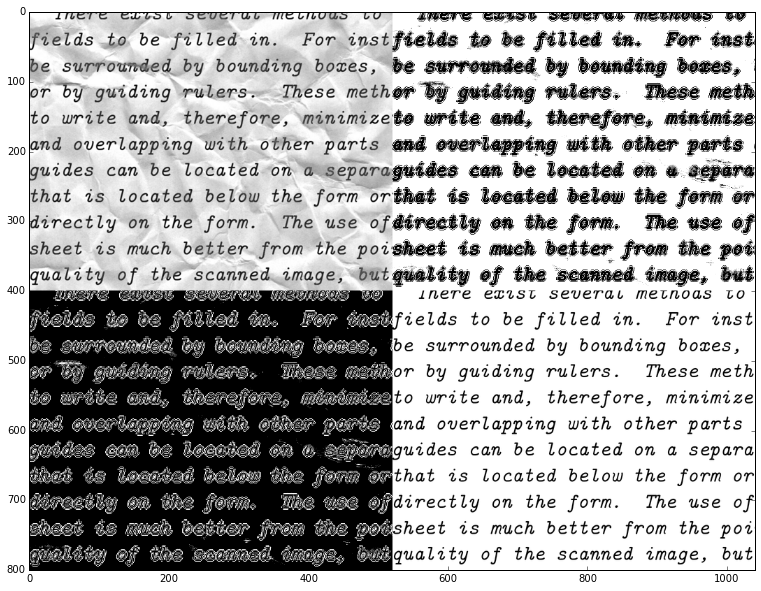

In [7]:
pred = denoised.reshape((image.shape[0]-patch_size+1, image.shape[1]-patch_size+1))
actual = image[patch_center:image.shape[0]-patch_center, patch_center:image.shape[1]-patch_center]
cleaned = clean[patch_center:clean.shape[0]-patch_center, patch_center:clean.shape[1]-patch_center]
diff = np.abs(cleaned - pred)
imshow(
    np.concatenate([
        np.concatenate([actual, pred], axis=1),
        np.concatenate([diff, cleaned], axis=1)
    ]), cmap='gray')

In [8]:
mean_squared_error(pred, actual)

0.093217630092012907

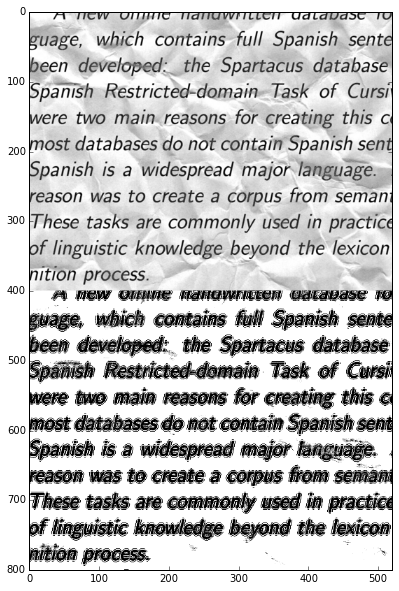

In [15]:
image = imread('test/106.png')
denoised = apply_model(image, exp)
cleaned = denoised.reshape((image.shape[0]-patch_size+1, image.shape[1]-patch_size+1))
actual = image[patch_center:image.shape[0]-patch_center, patch_center:image.shape[1]-patch_center]
imshow(np.concatenate([actual, cleaned], axis=0), cmap='gray')